In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.1


In [3]:
# Check for GPU availability
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available.")
    # Additional information about the GPUs
    for gpu in gpu_available:
        print("GPU:", gpu)
else:
    print("No GPU available. Using CPU.")


GPU is available.
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 50

In [5]:
interim_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "snakes",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 856 files belonging to 3 classes.


In [6]:
interim_class_names = interim_dataset.class_names
interim_class_names

['1', '3', '6']

In [7]:
interim_snake_labels = { 1: 'Cobra', 3: 'Sri Lankan Krait', 6: 'Whip snakes' }

In [8]:
len(interim_dataset)

54

In [9]:
for image_batch, label_batch in interim_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(16, 256, 256, 3)
[2 1 2 1 0 2 0 2 1 0 1 1 2 1 0 0]


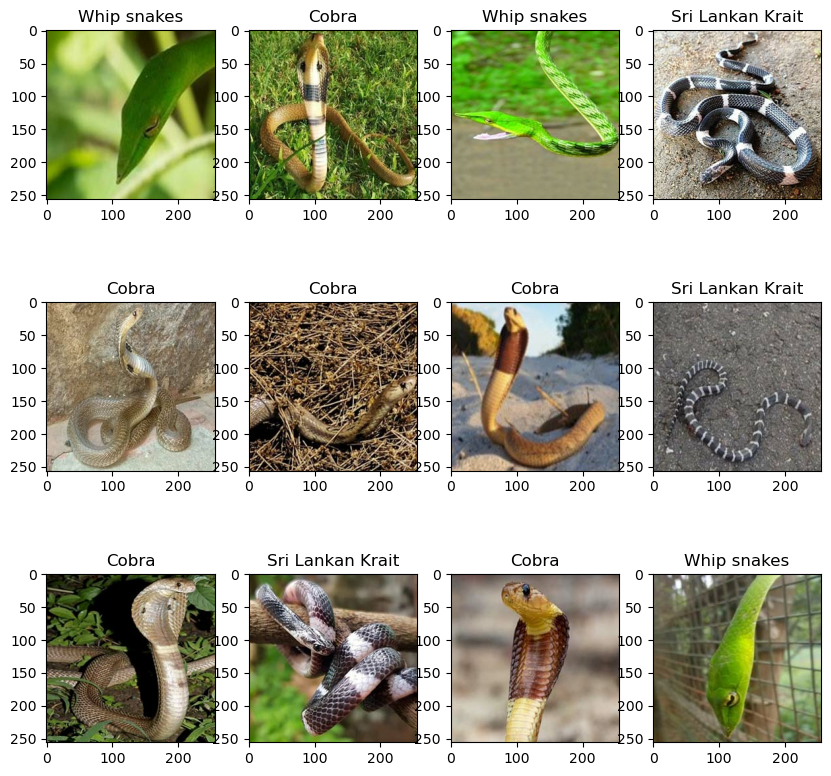

In [277]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in interim_dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(interim_snake_labels[int(interim_class_names[label_batch[i]])])

In [278]:
train_ds = interim_dataset.take(40)
print(len(train_ds))
test_ds = interim_dataset.skip(40)
# print(len(test_ds))
val_ds = test_ds.take(8)
print(len(val_ds))
test_ds = test_ds.skip(8)
print(len(test_ds))

40
8
6


In [279]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [280]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [281]:
input_shp = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

interim_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64,(3,3), activation='relu', input_shape = input_shp),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

interim_model.build(input_shape=input_shp)

In [282]:
interim_model.summary()



Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_45 (Sequential)  (16, 256, 256, 3)         0         
                                                                 
 sequential_44 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_59 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [283]:
interim_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [284]:
interim_history = interim_model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50


40/40 [==============================] - 9s 129ms/step - loss: 1.1152 - accuracy: 0.3187 - val_loss: 1.0872 - val_accuracy: 0.3438
Epoch 2/50
40/40 [==============================] - 5s 117ms/step - loss: 1.0841 - accuracy: 0.3438 - val_loss: 1.0489 - val_accuracy: 0.3672
Epoch 3/50
40/40 [==============================] - 5s 118ms/step - loss: 1.0314 - accuracy: 0.4500 - val_loss: 0.8866 - val_accuracy: 0.5859
Epoch 4/50
40/40 [==============================] - 5s 115ms/step - loss: 0.9766 - accuracy: 0.5391 - val_loss: 0.7509 - val_accuracy: 0.6094
Epoch 5/50
40/40 [==============================] - 5s 114ms/step - loss: 0.8660 - accuracy: 0.5672 - val_loss: 0.7111 - val_accuracy: 0.6797
Epoch 6/50
40/40 [==============================] - 5s 113ms/step - loss: 0.8579 - accuracy: 0.5453 - val_loss: 0.7146 - val_accuracy: 0.6250
Epoch 7/50
40/40 [==============================] - 5s 113ms/step - loss: 0.8595 - accuracy: 0.5844 - val_loss: 0.8016 - val_accuracy: 0.6172
Epoch 8/50
40/40 

In [285]:
scores = interim_model.evaluate(test_ds)

6/6 [==============================] - 1s 21ms/step - loss: 0.5778 - accuracy: 0.8068


In [286]:
print(interim_history)
print(interim_history.params)
print(interim_history.history.keys())

{'verbose': 1, 'epochs': 50, 'steps': 40}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and Validation Loss')

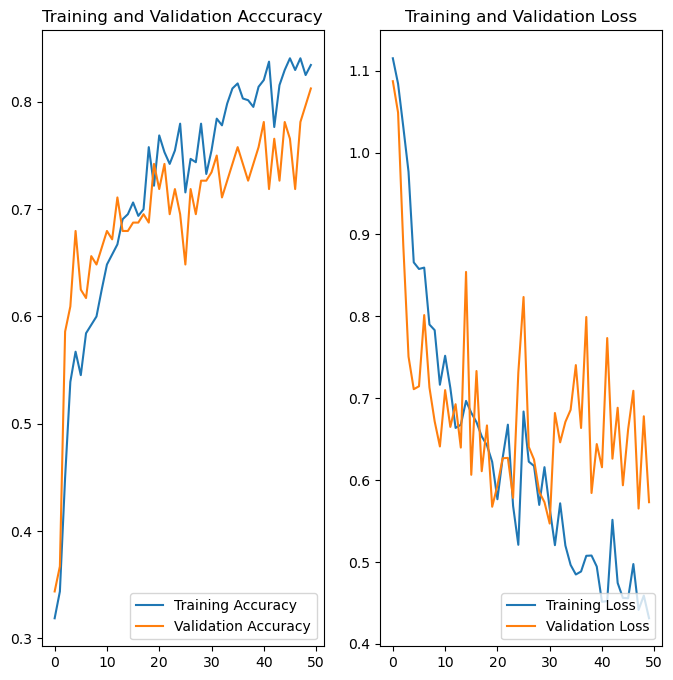

In [287]:
acc = interim_history.history['accuracy']
val_acc = interim_history.history['val_accuracy']
loss = interim_history.history['loss']
val_loss = interim_history.history['val_loss']

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Acccuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [293]:
# interim_model.save(f"../models/fifth_version")

INFO:tensorflow:Assets written to: ../models/fourth_version\assets


INFO:tensorflow:Assets written to: ../models/fourth_version\assets


first image to predict
actual label: 1
1/1 [==============================] - 0s 109ms/step
predicted label: 1


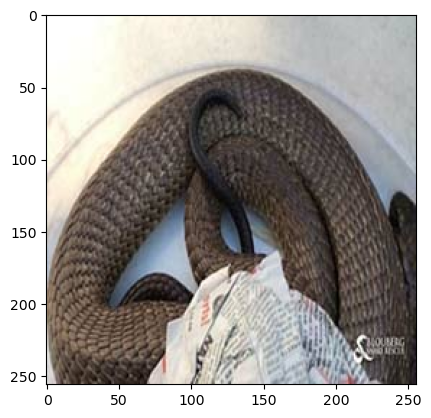

In [289]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",interim_class_names[first_label])
    
    batch_prediction = interim_model.predict(images_batch)
    print("predicted label:",interim_class_names[np.argmax(batch_prediction[0])])

In [290]:
def predict(interim_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = interim_model.predict(img_array)

    predicted_class = interim_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [291]:
test_snake_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test_snake_images",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 12 files belonging to 1 classes.


1/1 [==============================] - 0s 41ms/step


C:\Users\Kimuthu Kisal\AppData\Local\Temp\ipykernel_9420\161280882.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)


1/1 [==============================] - 0s 40ms/step


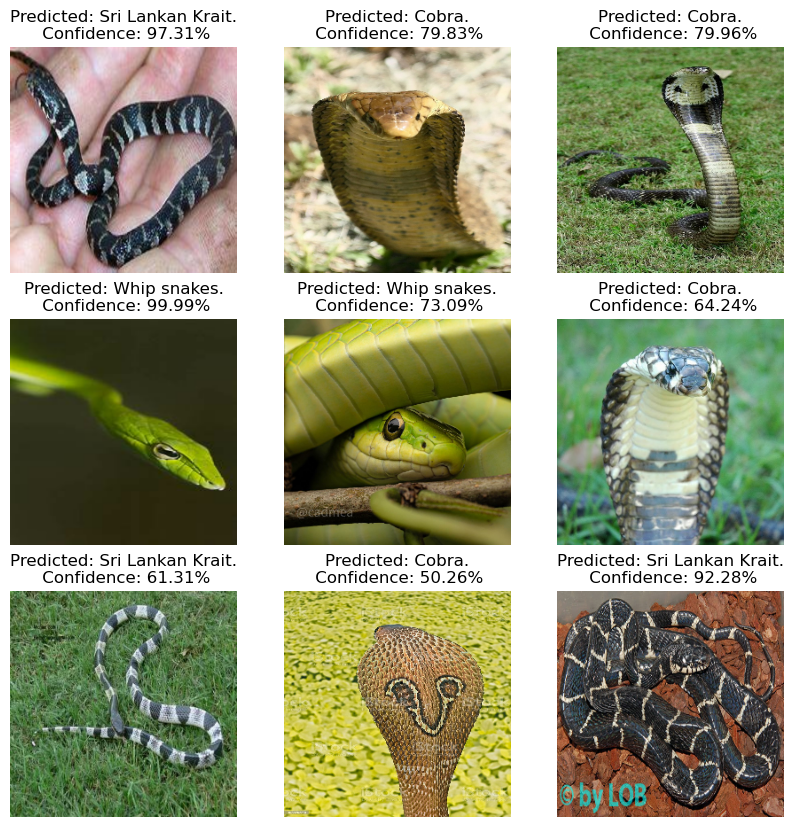

In [292]:
plt.figure(figsize=(10, 10))
plt.axis('off')

for images, labels in test_snake_ds.take(1):
    for i in range(9):
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(interim_model, images[i].numpy())
        actual_class = interim_class_names[labels[i]] 
        
#         plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.title(f"Predicted: {interim_snake_labels[int(predicted_class)]}.\n Confidence: {confidence}%")
        plt.axis('off')
# plt.axis("off")